In [4]:
import time
start_time = time.clock()
import numpy as np
import matplotlib.pylab as plt

In [5]:
#Use firn model from Arthern et al. for Greenland, Allison et al. for South Pole, 
#Kovacs et al. for conversion from density to index

#first define a few functions that will be useful.
def getDensity(thisDepth): #get density at a certain depth in feet
    thisDepth=thisDepth*0.3048 #convert feet to meters
    if southPoleFlag==0: #in Greenland
        if thisDepth <= 14.89:
            density=0.917-0.637*np.exp(-thisDepth/27)
        else:
            density=0.917-0.367*np.exp(-(thisDepth-14.89)/42)
    #n(z)=1.78-0.43e^(13.2z) z in km
    if southPoleFlag==1: #at South Pole
        nofz=1.78-0.43*np.exp(-thisDepth*0.0132)
        density=(nofz-1)/0.845
    else: #try weird stuff in the model
        if thisDepth <= 14.89:
            density=0.917-0.637*np.exp(-thisDepth/27)
        else:
            density=0.917-0.367*np.exp(-(thisDepth-14.89)/75)
    return density

def getIndex(thisDensity): #get index of refraction given some density
    ePrime=(1+0.845*thisDensity)**2
    index=np.sqrt(ePrime)        
    return index

def refractRay(index1,index2,theta1): #do refraction across some boundary
    if (np.sin(theta1)*index1/index2 > 1):
        theta2=theta1
    else:
        theta2=np.arcsin(np.sin(theta1)*index1/index2)
    return theta2


def propagateRay(thisInitialAngle, thisDepthRx, thisDepthTx, thisSurfaceTx, thisStepSize, thisNumSteps, whichSol):
    timeOfFlight=0
    totalPath=0
    angle1=thisInitialAngle*np.pi/180 #defined from zenith down, valid to 90 degrees
    locationOfRayEnd=(0,-1*thisDepthRx) #start at the antenna down the hole
    rayCoordH=[] # x coordinates of path
    rayCoordV=[] # y coordinates of path
    rayCoordH.append(locationOfRayEnd[0]*0.3048) # in m
    rayCoordV.append(locationOfRayEnd[1]*0.3048) # in m
    count = 0
    x=1
    temp =0
    surface_var = 0
    ayoo = 0
    local_save= (10000000000,100000000)
    for i in range (0,thisNumSteps*2): # numSteps is upper bound by triangle inequality
        # n1
        if(locationOfRayEnd[1] >= 0 and x> 0):
            index1=1
        else:
            index1 = getIndex(getDensity(-1*locationOfRayEnd[1]))

        # add new coordinates of step
        locationOfRayEnd = (locationOfRayEnd[0]+ np.sin(angle1)*thisStepSize,
                            locationOfRayEnd[1]+ x*np.cos(angle1)*thisStepSize)
        rayCoordH.append(locationOfRayEnd[0]*0.3048)
        rayCoordV.append(locationOfRayEnd[1]*0.3048)

        # n2
        totalPath=totalPath+thisStepSize #total path in ice
        timeOfFlight=timeOfFlight+thisStepSize*index1*0.3048/3e8*1e9 #in ns
        
        if(locationOfRayEnd[1] >= 0): #this is where i would like to put my x
            index2=1
        #angle2 = refractRay(index1,index2,angle1)
            
            surface_var +=1
            #print("ello")
            local_save = (locationOfRayEnd[0], locationOfRayEnd[1])
            if(np.sin(angle1) > index2/index1): #if TIR condition met, theta1=theta2 and we move downward
               
                x *=-1
                #if(whichSol == "D"):
                #    return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1,ayoo,surface_var
        
        else: 
            index2=getIndex(getDensity(-1*locationOfRayEnd[1]))
            #print(angle1, angle2)
        angle2 = refractRay(index1,index2,angle1)
        if(angle2 >= 89.9*np.pi/180):
            if(whichSol == "D"):
               
                return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1,ayoo,surface_var, totalPath,timeOfFlight
            else:
                #print('Kanye')
                x = -1
                local_save = (locationOfRayEnd[0], locationOfRayEnd[1])
        if(np.isnan(angle2)):
            return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1, ayoo,surface_var, totalPath,timeOfFlight
    # if down sol, we count and allow ray to continue/reflect, else break
        if(locationOfRayEnd[1] >= -1*thisDepthTx):
            #if(whichSol == "S"):
            if(whichSol == "D"):
                return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1,ayoo, surface_var, totalPath,timeOfFlight
            else:
                count =1
            #else:
             #   if(whichSol =="R"):
                    #print("2", temp, locationOfRayEnd[1], thisDepthTx)
              #      return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1
    #breaks specific to down solution;
    #break at some arbitrary height above surface, so we do not just continue up
    #break when the ray comes back down
        #if(whichSol == "S"):
        if(locationOfRayEnd[1] >= 200):
            return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1, ayoo,surface_var, totalPath,timeOfFlight
        if(whichSol == "R"):
            if(locationOfRayEnd[1] < -1*thisDepthTx and count ==1 and surface_var==0):
                return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1,ayoo,surface_var, totalPath,timeOfFlight
            elif(surface_var ==1):
                return local_save[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1, ayoo,surface_var,totalPath,timeOfFlight
            elif(local_save[0] < -1*thisDepthTx):
                ayoo = 1
                return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1, ayoo,surface_var,totalPath,timeOfFlight
            elif(locationOfRayEnd[0]> thisSurfaceTx):
                return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1, ayoo,surface_var,totalPath,timeOfFlight    
            
                
        elif(whichSol == "S"):
            if(locationOfRayEnd[1] < -1*thisDepthTx and count ==1 and surface_var ==1):
                #print("hello")
                return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1,ayoo,surface_var,totalPath,timeOfFlight
            elif(locationOfRayEnd[0]> thisSurfaceTx):
                return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1, ayoo,surface_var,totalPath,timeOfFlight

        # reset theta1 to theta2
        angle1 = angle2
        temp +=1
        # update total path length in ft. and time of flight in ns
        #totalPath=totalPath+thisStepSize #total path in ice
        #timeOfFlight=timeOfFlight+thisStepSize*index1*0.3048/3e8*1e9 #in ns
    return locationOfRayEnd[0], locationOfRayEnd[1], rayCoordH, rayCoordV, angle1, ayoo,surface_var,totalPath,timeOfFlight

In [6]:
#find the ray that connects the Tx and Rx, try first using "normal" refracting propagation.  Note that 
#in principle there could be 2 solutions, but this code right now only finds the first one, starting 
#from zenith down
#this code definitely works for two things below the ice, and may also work (I think it does but can't promise)
#for a tx or rx above the surface (but not both)

#the inputs:


southPoleFlag=1; #1 for South Pole, 0 for Greenland, 2 for changeable model for testing
depthTxm=[400] #depth in m of rx, positive number is below surface
surfaceTxm=[1500] #distance across surface between tx and rx in m




depthTx=np.zeros(len(depthTxm))
#depthRx=np.zeros(len(depthTxm))
surfaceTx=np.zeros(len(surfaceTxm))

for k in range(0,len(depthTxm)):
    depthTx[k]=depthTxm[k]*3.28
    surfaceTx[k]=surfaceTxm[k]*3.28
#    depthTx[k]=depthTxm[k]*3.28

#iterate to propagate the ray
stepSize=5 #in feet
totalPathAll=[]
timeOfFlightAll=[]
initialAngleAll=[]
normalFlagAll=[]
timeOfFlightDirAll=[] #direct straight line ray
totalPathDirAll=[] #direct straight line ray

end_depthtop = 8000*3.28084
start_depthtop = depthTx[k]
end_depthbottom = 8000*3.28084
start_depthbottom = depthTx[k]
ello =0
shallowest_depth = 0
deepest_depth = 10000000
svar =1000000000000
dvar =0
u = 100000000
v = 0
top = 0
bottom = 0
top1 = 0
bottom1= 0

('top', 1312.0, 13779.36, 26246.72)
('bottom', 1312.0, 13779.36, 26246.72)
****Trying Direct Ray Tracing...
****Trying Direct Ray Tracing...
___________________________
top


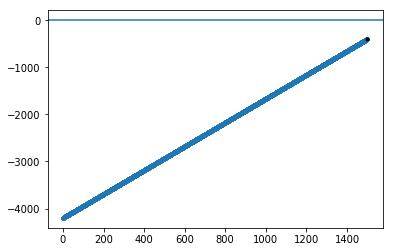

bottom


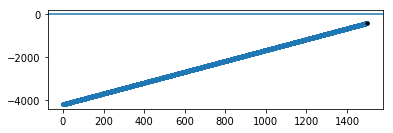

1312.0
('what it is saying is min', 0.1462333971062501, 4199.948928000001)
('what it is saying is max', 0.1462333971062501, 4199.948928000001)
('total Path:', 'shallow', 13402.886766957326, 'deep', 13402.886766957326)
____________________________
('min holder top', 0.1462333971062501)
ELLO
HEY
('top', 1312.0, 7545.68, 13779.36)
('bottom', 13779.36, 20013.04, 26246.72)
****Trying Direct Ray Tracing...
****Trying Direct Ray Tracing...
___________________________
top


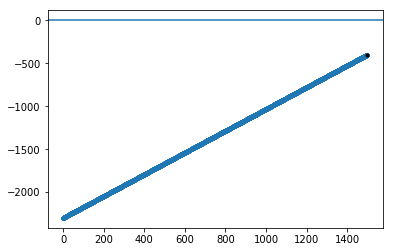

bottom


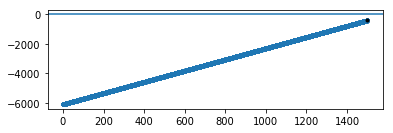

1312.0
('what it is saying is min', 0.05704924773134241, 2299.923264)
('what it is saying is max', 0.2592510521217835, 6099.9745920000005)
('total Path:', 'shallow', 7941.399972561816, 'deep', 19338.123585639874)
____________________________
('min holder top', 0.05704924773134241)
ELLO
HEY
('top', 1312.0, 4428.84, 7545.68)
('bottom', 20013.04, 23129.88, 26246.72)
****Trying Direct Ray Tracing...
****Trying Direct Ray Tracing...
___________________________
top


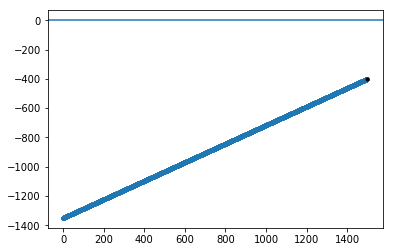

bottom


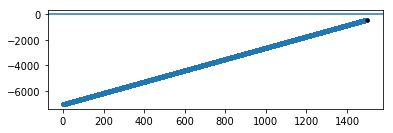

1312.0
('what it is saying is min', 0.12055269596552805, 1349.9104320000001)
('what it is saying is max', 0.18840348374068322, 7049.987424000001)
('total Path:', 'shallow', 5824.575849468096, 'deep', 22366.273012050497)
____________________________
('min holder top', 0.12055269596552805)
ELLO
HEY
('top', 1312.0, 2870.42, 4428.84)
('bottom', 23129.88, 24688.300000000003, 26246.72)
****Trying Direct Ray Tracing...
****Trying Direct Ray Tracing...
___________________________
top


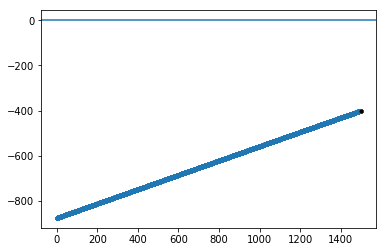

bottom


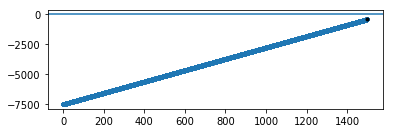

1312.0
('what it is saying is min', 0.0035525699494515983, 874.9040160000001)
('what it is saying is max', 0.328879226779072, 7524.993840000001)
('total Path:', 'shallow', 5160.919531633475, 'deep', 23889.452422887513)
____________________________
('min holder top', 0.0035525699494515983)
ELLO
HEY
('top', 1312.0, 2091.21, 2870.42)
('bottom', 24688.300000000003, 25467.510000000002, 26246.72)
****Trying Direct Ray Tracing...
****Trying Direct Ray Tracing...
___________________________
top


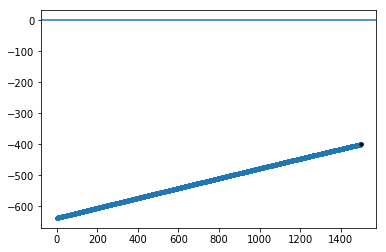

bottom


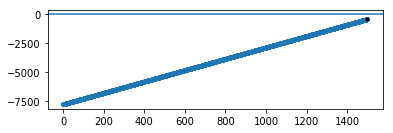

1312.0
('what it is saying is min', 0.13308998294160332, 637.4008080000001)
('what it is saying is max', 0.19403133578083567, 7762.497048000001)
('total Path:', 'shallow', 4980.905334614177, 'deep', 24651.39031027795)
____________________________
('min holder top', 0.13308998294160332)
ELLO
HEY
('top', 1312.0, 1701.605, 2091.21)
('bottom', 25467.510000000002, 25857.115, 26246.72)
****Trying Direct Ray Tracing...
****Trying Direct Ray Tracing...
___________________________
top


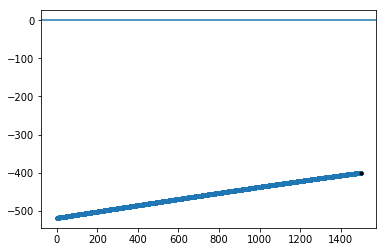

bottom


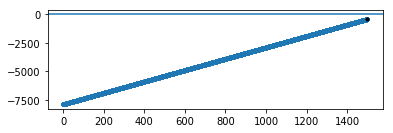

1312.0
('what it is saying is min', 0.17836446527274769, 518.649204)
('what it is saying is max', 0.2524770635563509, 7881.248652000001)
('total Path:', 'shallow', 4934.851101156847, 'deep', 25034.125644403095)
____________________________
('min holder top', 0.17836446527274769)
ELLO
HEY
('top', 1312.0, 1506.8025, 1701.605)
('bottom', 25857.115, 26051.917500000003, 26246.72)
****Trying Direct Ray Tracing...
****Trying Direct Ray Tracing...
___________________________
top


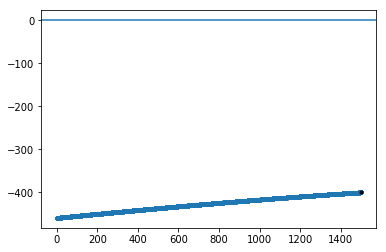

bottom


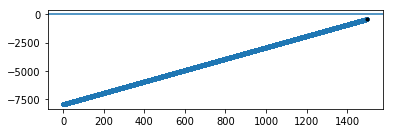

1312.0
('what it is saying is min', 0.5490915979464405, 459.27340200000003)
('what it is saying is max', 0.4069805623238742, 7940.624454000002)
('total Path:', 'shallow', 4922.117215797027, 'deep', 25225.723393175773)
____________________________
('min holder top', 0.5490915979464405)
ELLO
HEY
('top', 1312.0, 1409.40125, 1506.8025)
('bottom', 26051.917500000003, 26149.318750000002, 26246.72)
****Trying Direct Ray Tracing...
****Trying Direct Ray Tracing...
___________________________
top


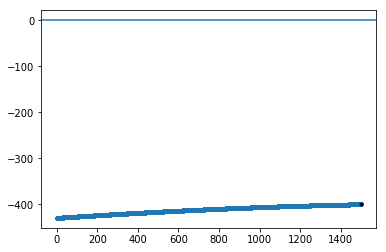

bottom


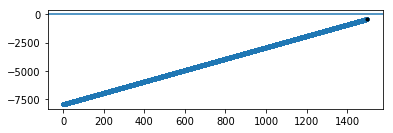

1312.0
('what it is saying is min', 0.8389433480251098, 429.58550099999997)
('what it is saying is max', 0.5270791876751149, 7970.312355000001)
('total Path:', 'shallow', 4918.302667440078, 'deep', 25321.579787983443)
____________________________
('min holder top', 0.8389433480251098)
ELLO
HEY
('top', 1312.0, 1360.700625, 1409.40125)
('bottom', 26149.318750000002, 26198.019375000003, 26246.72)
****Trying Direct Ray Tracing...
****Trying Direct Ray Tracing...
___________________________
top


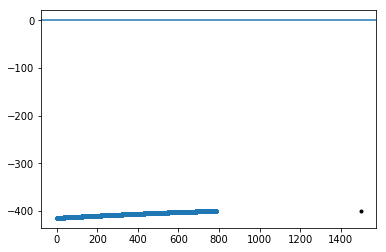

bottom


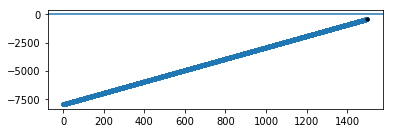

1312.0
('what it is saying is min', 712.574045366329, 414.7415505)
('what it is saying is max', 0.3111319078559711, 7985.1563055000015)
('total Path:', 'shallow', 2582.632797866757, 'deep', 25368.626770381557)
____________________________
('min holder top', 712.574045366329)
KANYE
1
HEY
('top', 1360.700625, 1385.0509375, 1409.40125)
('bottom', 26198.019375000003, 26222.369687500002, 26246.72)
****Trying Direct Ray Tracing...
****Trying Direct Ray Tracing...
___________________________
top


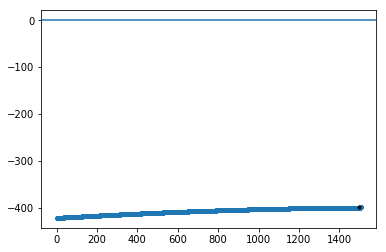

bottom


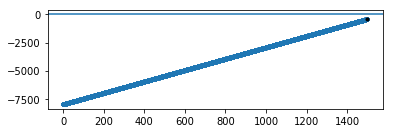

1312.0
('what it is saying is min', 8.244834128624682, 422.16352575)
('what it is saying is max', 0.4529060742425315, 7992.578280750001)
('total Path:', 'shallow', 4947.691053853535, 'deep', 25393.049052265957)
____________________________
('min holder top', 8.244834128624682)
KANYE
HEY
('top', 1385.0509375, 1397.22609375, 1409.40125)
('bottom', 26222.369687500002, 26234.54484375, 26246.72)
****Trying Direct Ray Tracing...
****Trying Direct Ray Tracing...
___________________________
top


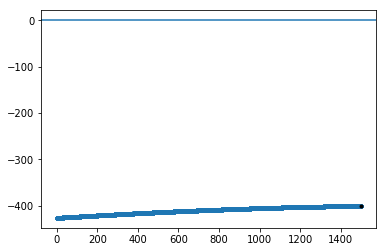

bottom


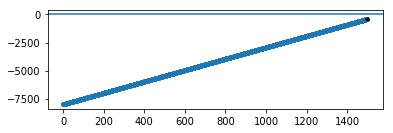

1312.0
('what it is saying is min', 0.19442788952864393, 425.87451337500005)
('what it is saying is max', 0.26071673051410044, 7996.289268375001)
('total Path:', 'shallow', 4921.471131647848, 'deep', 25404.364598119046)
____________________________
('min holder top', 0.19442788952864393)
ELLO
HEY
('top', 1385.0509375, 1391.1385156249999, 1397.22609375)
('bottom', 26234.54484375, 26240.632421875, 26246.72)
****Trying Direct Ray Tracing...
****Trying Direct Ray Tracing...
___________________________
top


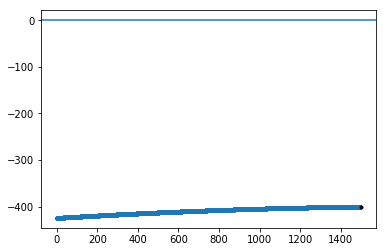

bottom


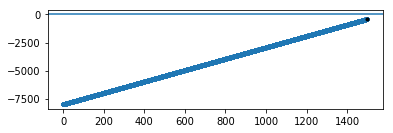

1312.0
('what it is saying is min', 4.528775434204587, 424.0190195625)
('what it is saying is max', 0.16533341434163615, 7998.1447621875)
('total Path:', 'shallow', 4905.876805485154, 'deep', 25410.02237103243)
____________________________
('min holder top', 4.528775434204587)
KANYE
1
HEY
('top', 1391.1385156249999, 1394.1823046875, 1397.22609375)
('bottom', 26240.632421875, 26243.6762109375, 26246.72)
****Trying Direct Ray Tracing...
****Trying Direct Ray Tracing...
___________________________
top


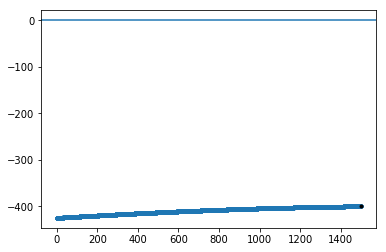

bottom


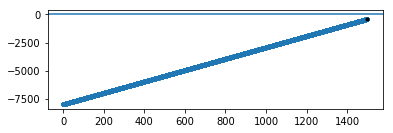

1312.0
('what it is saying is min', 1.9680533859388505, 424.94676646875)
('what it is saying is max', 0.17636692488752853, 7999.072509093751)
('total Path:', 'shallow', 4914.326338729395, 'deep', 25412.8512574902)
____________________________
('min holder top', 1.9680533859388505)
KANYE
HEY
('top', 1394.1823046875, 1395.70419921875, 1397.22609375)
('bottom', 26243.6762109375, 26245.19810546875, 26246.72)
****Trying Direct Ray Tracing...
****Trying Direct Ray Tracing...
___________________________
top


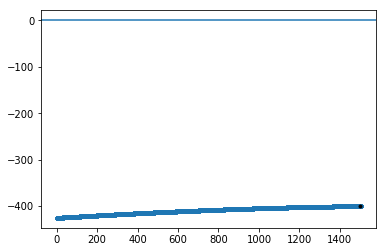

bottom


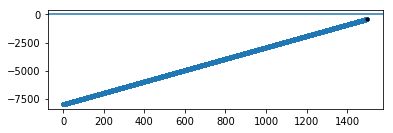

1312.0
('what it is saying is min', 5.127607013837337, 425.41063992187503)
('what it is saying is max', 0.09793540683924355, 7999.536382546875)
('total Path:', 'shallow', 4937.629253689214, 'deep', 25414.265700718322)
____________________________
('min holder top', 5.127607013837337)
KANYE
HEY
('top', 1395.70419921875, 1396.465146484375, 1397.22609375)
('bottom', 26245.19810546875, 26245.959052734375, 26246.72)
****Trying Direct Ray Tracing...
****Trying Direct Ray Tracing...
___________________________
top


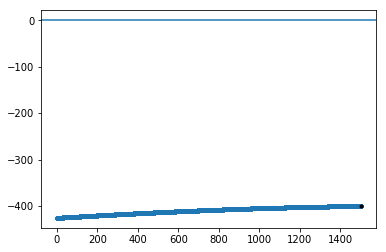

bottom


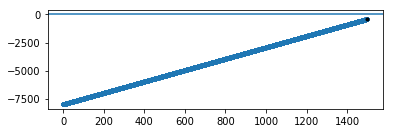

1312.0
('what it is saying is min', 2.5870404587720808, 425.6425766484375)
('what it is saying is max', 0.07288397869811779, 7999.768319273438)
('total Path:', 'shallow', 4929.307426268364, 'deep', 25414.97292233219)
____________________________
('min holder top', 2.5870404587720808)
KANYE
HEY
('top', 1396.465146484375, 1396.8456201171875, 1397.22609375)
('bottom', 26245.959052734375, 26246.33952636719, 26246.72)
****Trying Direct Ray Tracing...
****Trying Direct Ray Tracing...
___________________________
top


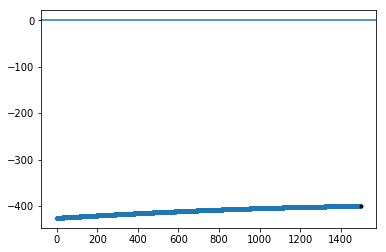

bottom


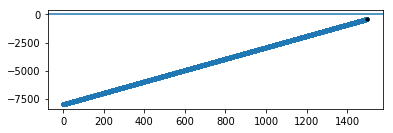

1312.0
('what it is saying is min', 4.226805289127314, 425.7585450117188)
('what it is saying is max', 0.06922330666897154, 7999.88428763672)
('total Path:', 'shallow', 4906.960629759617, 'deep', 25415.326533139065)
____________________________
('min holder top', 4.226805289127314)
KANYE
HEY
('shallowest depth', 425.87451337500005, 'deepest depth', 7999.88428763672)


In [7]:
for k in range(0,len(depthTx)):
    
    best_HD = []
    best_VD =[]

    while (end_depthtop - start_depthtop > .5 and start_depthtop < end_depthtop and \
               end_depthbottom - start_depthbottom > .5 and start_depthbottom < end_depthbottom):
        s = (end_depthtop + start_depthtop) / 2.0
        print("top",start_depthtop, s, end_depthtop)
        t = (end_depthbottom + start_depthbottom) / 2.0
        print("bottom", start_depthbottom, t, end_depthbottom)
        depthRxtop=[s] #depth in m of tx, negative number for above-surface pulser, positive for below surface
        depthRxbottom =[t]
        #print("top", depthRxtop[0], depthTx[k])
        #print("bottom", depthRxbottom[0], depthTx[k])
        #for k in range(0,len(depthTxm)): #swap tx and rx if needed so code doesn't break if Tx/Rx swapped
        #if (depthTxm[k]<depthRx[0] **0.3048):
         #   depthTx1=depthRx[0]
          #  depthRx[0]=depthTxm[k]
           # depthRx[0] = depthRx[0]*3.28084
            #depthTxm[k]=depthTx1**0.3048
        min_holder = 100000000000
        normalRayFlag=0 #is it a normal ray, start this flag at 0.
        end = 90.0
        start = 0.0
        numSteps = 50000 # number of rays to estimate - larger is more accurate
        stepSize = (surfaceTx[k] + abs(depthTx[k] - depthRxbottom[0]*3.28084)) / numSteps # triangle inequality
        print("****Trying Direct Ray Tracing...")
        county =0
        while (end - start > .005 and start < end): 
            j = (end + start) / 2.0
            #print(start,j,end)

            # code
            # ===============================================
            final_x, final_y, rayCoordH_D,rayCoordV_D, angle1, ayoo,surface_var, totalPathb, timeOfFlightb \
                = propagateRay(j, depthRxbottom[0], depthTx[k], surfaceTx[k], stepSize, numSteps, "D")
            # ========================================
            xdist = abs(final_x - surfaceTx[k])
            ydist = abs(final_y - (-1*depthTx[k]))
            #print(totalPath, timeOfFlight)
            #print(xdist, ydist)
            min_both = (xdist**2 + ydist**2) **(.5)
            #plt.figure(1)
            #ax= plt.subplot(111)
            
            #plt.axhline(y=0)
            #plt.plot(rayCoordH_D,rayCoordV_D, linestyle=":", marker='.')
            #plt.plot(surfaceTxm[k], -1*depthTx[k]*0.3048, marker='o', markersize=3, color="black")
            #plt.show()
            #print(depthTx[k])
            #print(min_holderD, s)
            #print("min_both", min_both)
            if (min_both < min_holder) :
                min_holder = min_both
                minRayCoordH_Dbottom = rayCoordH_D
                minRayCoordV_Dbottom = rayCoordV_D
                minAngle = j
                min_holderDbottom= min_holder
                totalPathDbottom = totalPathb
                timeOfFlightDbottom = timeOfFlightb
            #print("min holder", min_both)
            #county +=1
            #if(surface_var == 0):
            if(final_x > surfaceTx[k]):

                end = j
                # rerun loop
            else:
                start = j
                # rerun loop
        
        min_holder = 100000000000
        normalRayFlag=0 #is it a normal ray, start this flag at 0.
        end = 90.0
        start = 0.0
        numSteps = 50000 # number of rays to estimate - larger is more accurate
        stepSize = (surfaceTx[k] + abs(depthTx[k] - depthRxtop[0]*3.28084)) / numSteps # triangle inequality
        print("****Trying Direct Ray Tracing...")
        county =0
        while (end - start > .005 and start < end): 
            j = (end + start) / 2.0
            #print(start,j,end)

            # code
            # ===============================================
            final_x, final_y, rayCoordH_D,rayCoordV_D, angle1, ayoo,surface_var,totalPatht,timeOfFlightt \
                = propagateRay(j, depthRxtop[0], depthTx[k], surfaceTx[k], stepSize, numSteps, "D")
            # ========================================
            #print(totalPath, timeOfFlight)
            xdist = abs(final_x - surfaceTx[k])
            ydist = abs(final_y - (-1*depthTx[k]))
            #print(xdist, ydist)
            min_both = (xdist**2 + ydist**2) **(.5)
            #plt.figure(1)
            #ax= plt.subplot(111)
            
            #plt.axhline(y=0)
            #plt.plot(rayCoordH_D,rayCoordV_D, linestyle=":", marker='.')
            #plt.plot(surfaceTxm[k], -1*depthTx[k]*0.3048, marker='o', markersize=3, color="black")
            #plt.show()
            #print(depthTx[k])
            #print(min_holderD, s)
            #print("min_both", min_both)
            if (min_both < min_holder) :
                min_holder = min_both
                minRayCoordH_Dtop = rayCoordH_D
                minRayCoordV_Dtop = rayCoordV_D
                minAngle = j
                min_holderDtop = min_holder
                totalPathDtop = totalPatht
                timeOfFlightDtop = timeOfFlightt
            #print("min holder", min_both)
            #county +=1
            #if(surface_var == 0):
            if(final_x > surfaceTx[k]):

                end = j
                # rerun loop
            else:
                start = j
        #if (final_y>=-1.*depthTx[k]-5 and final_y<-1.*depthTx[k]+5):
         #   normalRayFlag=1
            #print("Ray Tracer Converged, Normal Mode")
            #print("Initial Angle Downhole: ", j, " Final Angle in Ice: ", angle1*180/np.pi)
            #print("Horizontal Distance at End: ", locationOfRayEnd[0], " ft.")
            #print("Horizontal Distance at End: ", locationOfRayEnd[0]/3.3, " m")

            #print("Depth at End: ",locationOfRayEnd[1],"ft.")
            #print("Time Of Flight Under Ice: ", timeOfFlight, " ns")
            #print("Length of Path Under Ice: ", totalPath, " ft.")
        #else:
            #print("****Ray Tracer Did Not Converge with Normal Mode, there is no solution")

            #totalPathAll.append(totalPath)
            #timeOfFlightAll.append(timeOfFlight)
            #normalFlagAll.append(normalRayFlag)
            #initialAngleAll.append(j)
        
            #plot ray
        print("___________________________")
        plt.figure(1)
        ax= plt.subplot(111)
        print("top")
        plt.axhline(y=0)
        plt.plot(minRayCoordH_Dtop,minRayCoordV_Dtop, linestyle=":", marker='.')
        plt.plot(surfaceTxm[k], -1*depthTx[k]*0.3048, marker='o', markersize=3, color="black")
        plt.show()
        plt.figure(2)
        ax= plt.subplot(211)
        print("bottom")
        plt.axhline(y=0)
        plt.plot(minRayCoordH_Dbottom,minRayCoordV_Dbottom, linestyle=":", marker='.')
        plt.plot(surfaceTxm[k], -1*depthTx[k]*0.3048, marker='o', markersize=3, color="black")
        plt.show()
        print(depthTx[k])
        print("what it is saying is min", min_holderDtop*0.3048, s*0.3048)
        print("what it is saying is max", min_holderDbottom*0.3048, t*0.3048)
        print("total Path:", "shallow", totalPathDtop, "deep", totalPathDbottom)
        print("____________________________")
        #plt.figure(1)
        #ax= plt.subplot(111)
        print("min holder top", min_holderDtop*0.3048)
        if(min_holderDtop <= (3.28084)):
            print("ELLO")            
            end_depthtop = s
            hold_s = s
            if(s < svar):
                shallowest_HD = minRayCoordH_Dtop 
                shallowest_VD = minRayCoordV_Dtop
                shallowtotalPathDt = totalPathDtop
                shallowtimeOfFlightDt= timeOfFlightDtop
                shallowest_depth = s
                svar = s
            top = 1
        else:
            print("KANYE")
            #if we come out of shallowest or end up above shallowest want to move down
            #if(end_depthtop - start_depthtop > .005 and start_depthtop < end_depthtop):
            if(top == 1):
                top1 = 1
                top = 2
                print("1")

                start_depthtop = s
            elif(top1 == 1):
                start_depthtop = s
                end_depthtop = hold_s
            
            
            else:
                print("4")
                start_depthtop = s
        if(min_holderDbottom <= (3.28084)):
            print("HEY")
            
            start_depthbottom = t
            hold_t = t
            if(t > dvar):
                deepest_HD = minRayCoordH_Dbottom 
                deepest_VD = minRayCoordV_Dbottom
                deeptotalPathDb = totalPathDbottom
                deeptimeOfFlightDb= timeOfFlightDbottom
                deepest_depth = t
                dvar = t
            bottom =  1


            #end_depth = s
            #if (count == 1):
            #ello +=1
            #ax.set_ylim(ymin=-1600, ymax=0)
            #ax.set_xlim(xmin=0, xmax=5100)
            #plt.plot(minRayCoordH_D,minRayCoordV_D, linestyle=":", marker='.', color = "blue")
            #plt.plot(surfaceTxm[k], -1*depthRx[0]*0.3048, marker='o', markersize=3, color="yellow")
            #if(depthRx[0]< shallowest_depth):
            #    shallowest_depth = depthRx[0]
            #else:
             #   deepest_depth = depthRx[0]
            # rerun loop
        else:
            #if(end_depthbottom - start_depthbottom > .005 and start_depthbottom < end_depthbottom):
            if(bottom == 1):
                bottom1 = 1
                bottom = 2
                end_depthbottom= t

            elif(bottom1 == 1):
                start_depthbottom = t
                end_depthbottom = hold_t
            
            else:
                start_depthbottom = t
            #ax.set_ylim(ymin=-1600, ymax=0)
            #ax.set_xlim(xmin=0, xmax=5000)
            #plt.plot(minRayCoordH_D,minRayCoordV_D, linestyle=":", marker='.', color = "black")
            #plt.plot(surfaceTxm[k], -1*depthRx[0]*0.3048, marker='o', markersize=3, color="red")
    #plt.show
print("shallowest depth", shallowest_depth*0.3048, "deepest depth", deepest_depth*0.3048)


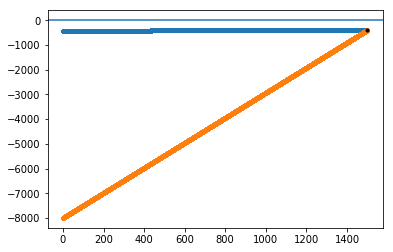

(425.87451337500005, 7999.88428763672)
('totalPaths; shallow: deep...ft', 4921.471131647848, 25415.326533139065)
('timesOfFlights; shallow: deep...ns', 8890.763451976984, 45962.546861018265)


In [8]:
### plt.figure(1)
ax= plt.subplot(111)
#ax.set_ylim(ymin=-200, ymax=-50)
#ax.set_xlim(xmin=4800, xmax=5200)
plt.axhline(y=0)
plt.plot(shallowest_HD,shallowest_VD, linestyle=":", marker='.')
plt.plot(deepest_HD,deepest_VD, linestyle=":", marker='.')
plt.plot(surfaceTxm[0], -1*depthTx[0]*0.3048, marker='o', markersize=3, color="black")
plt.show()
print(shallowest_depth*.3048, deepest_depth*.3048)
print("totalPaths; shallow: deep...ft", shallowtotalPathDt, deeptotalPathDb)
print("timesOfFlights; shallow: deep...ns",  shallowtimeOfFlightDt, deeptimeOfFlightDb)

('top', 1312.0, 3280.672, 5249.344)
('bottom', 1312.0, 3280.672, 5249.344)
****Trying Refracted Ray Tracing...
****Trying Refracted Ray Tracing...
___________________________
top


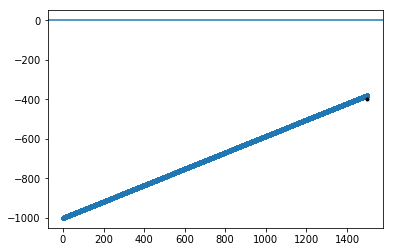

bottom


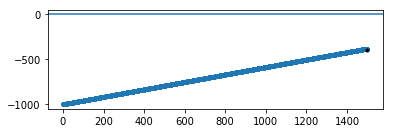

1312.0
('what it is saying is min', 20.281153779915808, 999.9488256000001)
('what it is saying is max', 20.281153779915808, 999.9488256000001)
('total Path:', 'shallow', 5324.392362240237, 'deep', 5324.392362240237)
____________________________
('min holder top', 20.281153779915808)
KANYE
4
('top', 3280.672, 4265.008, 5249.344)
('bottom', 3280.672, 4265.008, 5249.344)
****Trying Refracted Ray Tracing...
****Trying Refracted Ray Tracing...


KeyboardInterrupt: 

In [21]:
end_depthtop = 1600*3.28084
start_depthtop = depthTx[k]
end_depthbottom = 1600*3.28084
start_depthbottom = depthTx[k]
ello =0
shallowest_depth = 0
deepest_depth = 10000000
svar =1000000000000
dvar =0
u = 100000000
v = 0
top = 0
bottom = 0
top1 = 0
bottom1= 0
for k in range(0,len(depthTx)):
    
    best_HD = []
    best_VD =[]

    while (end_depthtop - start_depthtop > .5 and start_depthtop < end_depthtop \
               and end_depthbottom - start_depthbottom > .5 and start_depthbottom < end_depthbottom):
        s = (end_depthtop + start_depthtop) / 2.0
        print("top",start_depthtop, s, end_depthtop)
        t = (end_depthbottom + start_depthbottom) / 2.0
        print("bottom", start_depthbottom, t, end_depthbottom)
        depthRxtop=[s] #depth in m of tx, negative number for above-surface pulser, positive for below surface
        depthRxbottom =[t]
        #print("top", depthRxtop[0], depthTx[k])
        #print("bottom", depthRxbottom[0], depthTx[k])
        #for k in range(0,len(depthTxm)): #swap tx and rx if needed so code doesn't break if Tx/Rx swapped
        #if (depthTxm[k]<depthRx[0] **0.3048):
         #   depthTx1=depthRx[0]
          #  depthRx[0]=depthTxm[k]
           # depthRx[0] = depthRx[0]*3.28084
            #depthTxm[k]=depthTx1**0.3048
        min_holder = 100000000000
        normalRayFlag=0 #is it a normal ray, start this flag at 0.
        end = 90.0
        start = 0.0
        numSteps = 50000 # number of rays to estimate - larger is more accurate
        stepSize = (surfaceTx[k] + abs(depthTx[k] - depthRxbottom[0])) / numSteps # triangle inequality
        print("****Trying Refracted Ray Tracing...")
        county =0
        while (end - start > .005 and start < end): 
            j = (end + start) / 2.0
            #print(start,j,end)

            # code
            # ===============================================
            final_x, final_y, rayCoordH_R,rayCoordV_R, angle1, ayoo,surface_var, totalPathb,timeOfFlightb \
                = propagateRay(j, depthRxbottom[0], depthTx[k], surfaceTx[k], stepSize, numSteps, "R")
            # ========================================
            
            #plt.figure(1)
            #ax= plt.subplot(111)
            
            #plt.axhline(y=0)
            #plt.plot(rayCoordH_D,rayCoordV_D, linestyle=":", marker='.')
            #plt.plot(surfaceTxm[k], -1*depthTx[k]*0.3048, marker='o', markersize=3, color="black")
            #plt.show()
            #print(depthTx[k])
            #print(min_holderD, s)
            #print("min_both", min_both)
            if(surface_var == 0):
                xdist = abs(final_x - surfaceTx[k])
                ydist = abs(final_y - (-1*depthTx[k]))
                #print(xdist, ydist)
                min_both = (xdist**2 + ydist**2) **(.5)
                if (min_both < min_holder) :
                    min_holder = min_both
                    minRayCoordH_Rbottom = rayCoordH_R
                    minRayCoordV_Rbottom = rayCoordV_R
                    totalPathRbottom = totalPathb
                    timeOfFlightRbottom = timeOfFlightb
                    minAngle = j
                    min_holderRbottom= min_holder
            #print("min holder", min_both)
            #county +=1
            #if(surface_var == 0):
            if(final_x > surfaceTx[k]):

                end = j
                # rerun loop
            elif(ayoo ==1):
                end = j
            else:
                start = j
                # rerun loop
        
        min_holder = 100000000000
        normalRayFlag=0 #is it a normal ray, start this flag at 0.
        end = 90.0
        start = 0.0
        numSteps = 50000 # number of rays to estimate - larger is more accurate
        stepSize = (surfaceTx[k] + abs(depthTx[k] - depthRxtop[0])) / numSteps # triangle inequality
        print("****Trying Refracted Ray Tracing...")
        county =0
        while (end - start > .005 and start < end): 
            j = (end + start) / 2.0
            #print(start,j,end)

            # code
            # ===============================================
            final_x, final_y, rayCoordH_R,rayCoordV_R, angle1, ayoo,surface_var,  totalPatht,timeOfFlightt \
                = propagateRay(j, depthRxtop[0], depthTx[k], surfaceTx[k], stepSize, numSteps, "R")
            # ========================================
            
            #plt.figure(1)
            #ax= plt.subplot(111)
            
            #plt.axhline(y=0)
            #plt.plot(rayCoordH_D,rayCoordV_D, linestyle=":", marker='.')
            #plt.plot(surfaceTxm[k], -1*depthTx[k]*0.3048, marker='o', markersize=3, color="black")
            #plt.show()
            #print(depthTx[k])
            #print(min_holderD, s)
            #print("min_both", min_both)
            if(surface_var == 0):    
                xdist = abs(final_x - surfaceTx[k])
                ydist = abs(final_y - (-1*depthTx[k]))
                #print(xdist, ydist)
                min_both = (xdist**2 + ydist**2) **(.5)
                if (min_both < min_holder) :
                    min_holder = min_both
                    minRayCoordH_Rtop = rayCoordH_R
                    minRayCoordV_Rtop = rayCoordV_R
                    totalPathRtop = totalPatht
                    timeOfFlightRtop = timeOfFlightt
                    minAngle = j
                    min_holderRtop = min_holder
            #print("min holder", min_both)
            #county +=1
            #if(surface_var == 0):
            if(final_x > surfaceTx[k]):

                end = j
                # rerun loop
            elif(ayoo ==1):
                end = j
            else:
                start = j
        #if (final_y>=-1.*depthTx[k]-5 and final_y<-1.*depthTx[k]+5):
         #   normalRayFlag=1
            #print("Ray Tracer Converged, Normal Mode")
            #print("Initial Angle Downhole: ", j, " Final Angle in Ice: ", angle1*180/np.pi)
            #print("Horizontal Distance at End: ", locationOfRayEnd[0], " ft.")
            #print("Horizontal Distance at End: ", locationOfRayEnd[0]/3.3, " m")

            #print("Depth at End: ",locationOfRayEnd[1],"ft.")
            #print("Time Of Flight Under Ice: ", timeOfFlight, " ns")
            #print("Length of Path Under Ice: ", totalPath, " ft.")
        #else:
            #print("****Ray Tracer Did Not Converge with Normal Mode, there is no solution")

            #totalPathAll.append(totalPath)
            #timeOfFlightAll.append(timeOfFlight)
            #normalFlagAll.append(normalRayFlag)
            #initialAngleAll.append(j)
        
            #plot ray
        print("___________________________")
        plt.figure(1)
        ax= plt.subplot(111)
        print("top")
        plt.axhline(y=0)
        plt.plot(minRayCoordH_Rtop,minRayCoordV_Rtop, linestyle=":", marker='.')
        plt.plot(surfaceTxm[k], -1*depthTx[k]*0.3048, marker='o', markersize=3, color="black")
        plt.show()
        plt.figure(2)
        ax= plt.subplot(211)
        print("bottom")
        plt.axhline(y=0)
        plt.plot(minRayCoordH_Rbottom,minRayCoordV_Rbottom, linestyle=":", marker='.')
        plt.plot(surfaceTxm[k], -1*depthTx[k]*0.3048, marker='o', markersize=3, color="black")
        plt.show()
        print(depthTx[k])
        print("what it is saying is min", min_holderRtop*0.3048, s*0.3048)
        print("what it is saying is max", min_holderRbottom*0.3048, t*0.3048)
        print("total Path:", "shallow", totalPathRtop, "deep", totalPathRbottom)
        print("____________________________")
        #plt.figure(1)
        #ax= plt.subplot(111)
        print("min holder top", min_holderRtop*0.3048)
        if(min_holderRtop <= (3.28084)):
            print("ELLO")            
            end_depthtop = s
            hold_s = s
            if(s < svar):
                shallowest_HR = minRayCoordH_Rtop 
                shallowest_VR = minRayCoordV_Rtop
                shallowtotalPathRt = totalPathRtop
                shallowtimeOfFlightRt= timeOfFlightRtop
                shallowest_depth = s
                svar = s
            top = 1
        else:
            print("KANYE")
            #if we come out of shallowest or end up above shallowest want to move down
            #if(end_depthtop - start_depthtop > .005 and start_depthtop < end_depthtop):
            if(top == 1):
                top1 = 1
                top = 2
                print("1")

                start_depthtop = s
            elif(top1 == 1):
                start_depthtop = s
                end_depthtop = hold_s
            
            
            else:
                print("4")
                start_depthtop = s
        if(min_holderRbottom <= (3.28084)):
            print("HEY")
            
            start_depthbottom = t
            hold_t = t
            if(t > dvar):
                deepest_HR = minRayCoordH_Rbottom 
                deepest_VR = minRayCoordV_Rbottom
                deeptotalPathRb = totalPathRbottom
                deeptimeOfFlightRb= timeOfFlightRbottom
                deepest_depth = t
                dvar = t
            bottom =  1


            #end_depth = s
            #if (count == 1):
            #ello +=1
            #ax.set_ylim(ymin=-1600, ymax=0)
            #ax.set_xlim(xmin=0, xmax=5100)
            #plt.plot(minRayCoordH_D,minRayCoordV_D, linestyle=":", marker='.', color = "blue")
            #plt.plot(surfaceTxm[k], -1*depthRx[0]*0.3048, marker='o', markersize=3, color="yellow")
            #if(depthRx[0]< shallowest_depth):
            #    shallowest_depth = depthRx[0]
            #else:
             #   deepest_depth = depthRx[0]
            # rerun loop
        else:
            #if(end_depthbottom - start_depthbottom > .005 and start_depthbottom < end_depthbottom):
            if(bottom == 1):
                bottom1 = 1
                bottom = 2
                end_depthbottom= t

            elif(bottom1 == 1):
                start_depthbottom = t
                end_depthbottom = hold_t
            
            else:
                start_depthbottom = t
            #ax.set_ylim(ymin=-1600, ymax=0)
            #ax.set_xlim(xmin=0, xmax=5000)
            #plt.plot(minRayCoordH_D,minRayCoordV_D, linestyle=":", marker='.', color = "black")
            #plt.plot(surfaceTxm[k], -1*depthRx[0]*0.3048, marker='o', markersize=3, color="red")
    #plt.show()
print("shallowest depth", shallowest_depth*0.3048, "deepest depth", deepest_depth*0.3048)





In [ ]:
### plt.figure(1)
ax= plt.subplot(111)
#ax.set_ylim(ymin=-200, ymax=-50)
#ax.set_xlim(xmin=4800, xmax=5200)
plt.axhline(y=0)
plt.plot(shallowest_HR,shallowest_VR, linestyle=":", marker='.')
plt.plot(deepest_HR,deepest_VR, linestyle=":", marker='.')
plt.plot(surfaceTxm[0], -1*depthTx[0]*0.3048, marker='o', markersize=3, color="black")
plt.show()
print(shallowest_depth*.3048, deepest_depth*.3048)
print("totalPaths; shallow: deep...ft", shallowtotalPathRt, deeptotalPathRb)
print("timesOfFlights; shallow: deep...ns",  shallowtimeOfFlightRt, deeptimeOfFlightRb)

('top', 1312.0, 13779.36, 26246.72)
('bottom', 1312.0, 13779.36, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


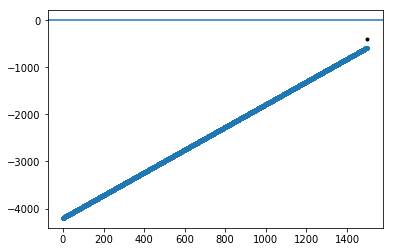

bottom


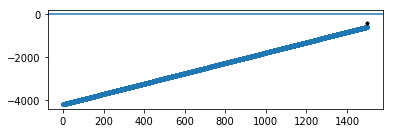

1312.0
('what it is saying is min', 179.6645606801979, 4199.948928000001)
('what it is saying is max', 179.6645606801979, 4199.948928000001)
('total Path:', 'shallow', 12856.561731197771, 'deep', 12856.561731197771)
____________________________
('min holder top', 179.6645606801979)
KANYE
4
('top', 13779.36, 20013.04, 26246.72)
('bottom', 13779.36, 20013.04, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


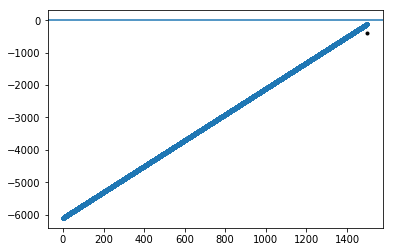

bottom


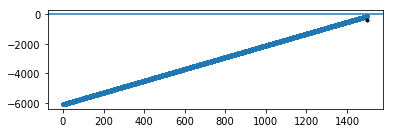

1312.0
('what it is saying is min', 282.51998219108043, 6099.9745920000005)
('what it is saying is max', 282.51998219108043, 6099.9745920000005)
('total Path:', 'shallow', 20235.200126414813, 'deep', 20235.200126414813)
____________________________
('min holder top', 282.51998219108043)
KANYE
4
('top', 20013.04, 23129.88, 26246.72)
('bottom', 20013.04, 23129.88, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


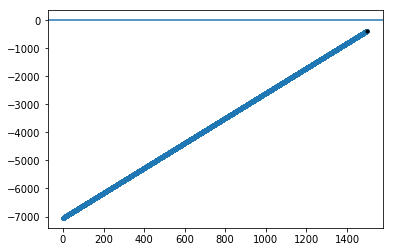

bottom


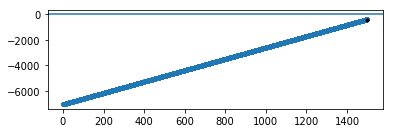

1312.0
('what it is saying is min', 27.887749378079086, 7049.987424000001)
('what it is saying is max', 27.887749378079086, 7049.987424000001)
('total Path:', 'shallow', 22455.00638159181, 'deep', 22455.00638159181)
____________________________
('min holder top', 27.887749378079086)
KANYE
4
('top', 23129.88, 24688.300000000003, 26246.72)
('bottom', 23129.88, 24688.300000000003, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


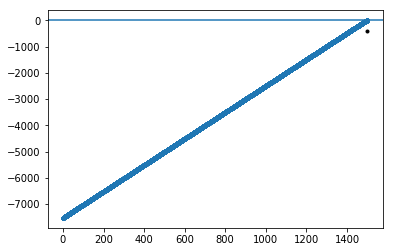

bottom


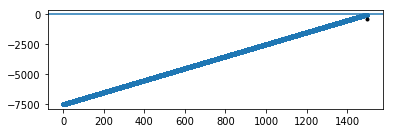

1312.0
('what it is saying is min', 393.96110636265655, 7524.993840000001)
('what it is saying is max', 393.96110636265655, 7524.993840000001)
('total Path:', 'shallow', 25154.8447739816, 'deep', 25154.8447739816)
____________________________
('min holder top', 393.96110636265655)
KANYE
4
('top', 24688.300000000003, 25467.510000000002, 26246.72)
('bottom', 24688.300000000003, 25467.510000000002, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


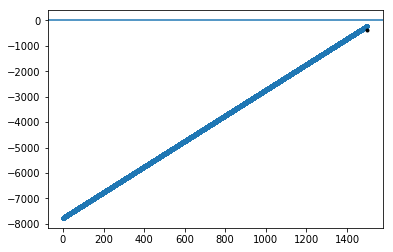

bottom


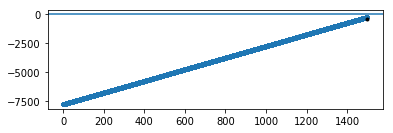

1312.0
('what it is saying is min', 175.52638184829027, 7762.497048000001)
('what it is saying is max', 175.52638184829027, 7762.497048000001)
('total Path:', 'shallow', 25216.02680261652, 'deep', 25216.02680261652)
____________________________
('min holder top', 175.52638184829027)
KANYE
4
('top', 25467.510000000002, 25857.115, 26246.72)
('bottom', 25467.510000000002, 25857.115, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


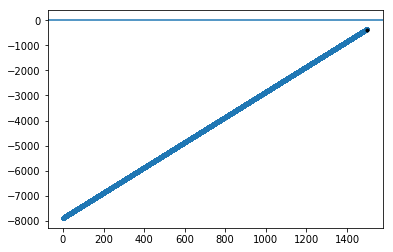

bottom


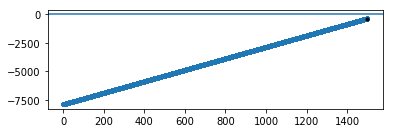

1312.0
('what it is saying is min', 57.57468552381222, 7881.248652000001)
('what it is saying is max', 57.57468552381222, 7881.248652000001)
('total Path:', 'shallow', 25218.602626194133, 'deep', 25218.602626194133)
____________________________
('min holder top', 57.57468552381222)
KANYE
4
('top', 25857.115, 26051.917500000003, 26246.72)
('bottom', 25857.115, 26051.917500000003, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


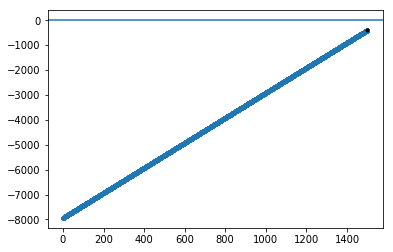

bottom


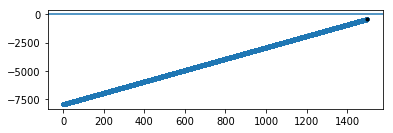

1312.0
('what it is saying is min', 1.608114061321758, 7940.624454000002)
('what it is saying is max', 1.608114061321758, 7940.624454000002)
('total Path:', 'shallow', 25219.234651915773, 'deep', 25219.234651915773)
____________________________
('min holder top', 1.608114061321758)
KANYE
4
('top', 26051.917500000003, 26149.318750000002, 26246.72)
('bottom', 26051.917500000003, 26149.318750000002, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


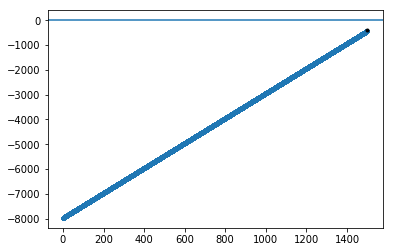

bottom


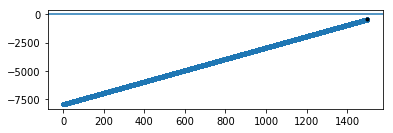

1312.0
('what it is saying is min', 31.266831667922457, 7970.312355000001)
('what it is saying is max', 31.266831667922457, 7970.312355000001)
('total Path:', 'shallow', 25219.327640615713, 'deep', 25219.327640615713)
____________________________
('min holder top', 31.266831667922457)
KANYE
4
('top', 26149.318750000002, 26198.019375000003, 26246.72)
('bottom', 26149.318750000002, 26198.019375000003, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


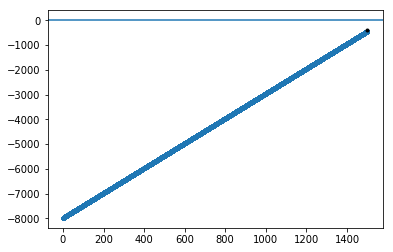

bottom


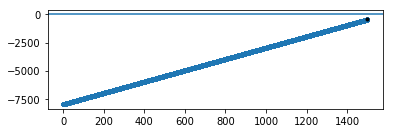

1312.0
('what it is saying is min', 46.06805646837251, 7985.1563055000015)
('what it is saying is max', 46.06805646837251, 7985.1563055000015)
('total Path:', 'shallow', 25219.469113588984, 'deep', 25219.469113588984)
____________________________
('min holder top', 46.06805646837251)
KANYE
4
('top', 26198.019375000003, 26222.369687500002, 26246.72)
('bottom', 26198.019375000003, 26222.369687500002, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


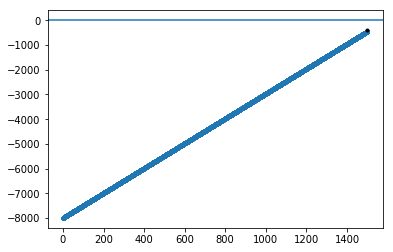

bottom


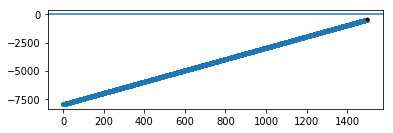

1312.0
('what it is saying is min', 53.57293068478668, 7992.578280750001)
('what it is saying is max', 53.57293068478668, 7992.578280750001)
('total Path:', 'shallow', 25219.191141197636, 'deep', 25219.191141197636)
____________________________
('min holder top', 53.57293068478668)
KANYE
4
('top', 26222.369687500002, 26234.54484375, 26246.72)
('bottom', 26222.369687500002, 26234.54484375, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


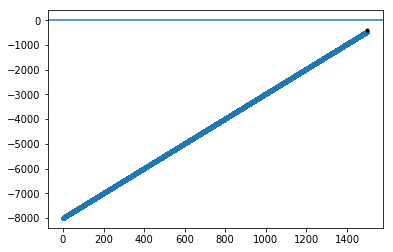

bottom


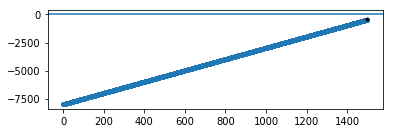

1312.0
('what it is saying is min', 57.239993343979435, 7996.289268375001)
('what it is saying is max', 57.239993343979435, 7996.289268375001)
('total Path:', 'shallow', 25219.33779656979, 'deep', 25219.33779656979)
____________________________
('min holder top', 57.239993343979435)
KANYE
4
('top', 26234.54484375, 26240.632421875, 26246.72)
('bottom', 26234.54484375, 26240.632421875, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


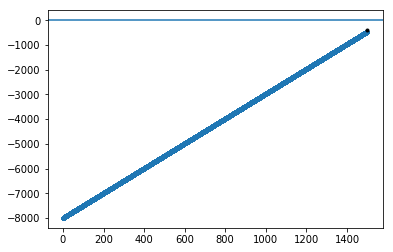

bottom


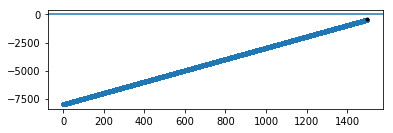

1312.0
('what it is saying is min', 59.163677424971745, 7998.1447621875)
('what it is saying is max', 59.163677424971745, 7998.1447621875)
('total Path:', 'shallow', 25219.109533233353, 'deep', 25219.109533233353)
____________________________
('min holder top', 59.163677424971745)
KANYE
4
('top', 26240.632421875, 26243.6762109375, 26246.72)
('bottom', 26240.632421875, 26243.6762109375, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


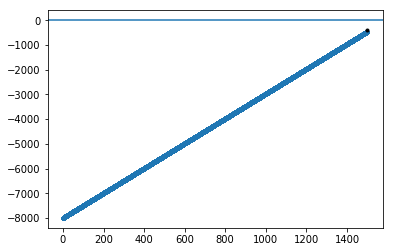

bottom


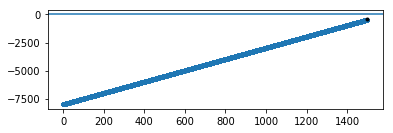

1312.0
('what it is saying is min', 60.03653267204926, 7999.072509093751)
('what it is saying is max', 60.03653267204926, 7999.072509093751)
('total Path:', 'shallow', 25219.29309653764, 'deep', 25219.29309653764)
____________________________
('min holder top', 60.03653267204926)
KANYE
4
('top', 26243.6762109375, 26245.19810546875, 26246.72)
('bottom', 26243.6762109375, 26245.19810546875, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


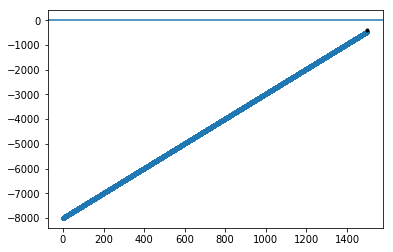

bottom


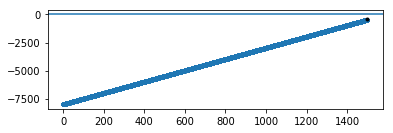

1312.0
('what it is saying is min', 60.47301566323275, 7999.536382546875)
('what it is saying is max', 60.47301566323275, 7999.536382546875)
('total Path:', 'shallow', 25219.384695529006, 'deep', 25219.384695529006)
____________________________
('min holder top', 60.47301566323275)
KANYE
4
('top', 26245.19810546875, 26245.959052734375, 26246.72)
('bottom', 26245.19810546875, 26245.959052734375, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


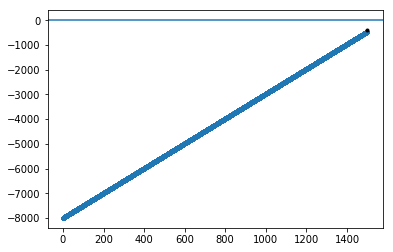

bottom


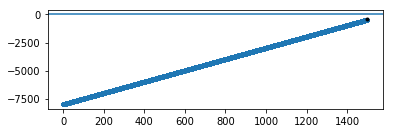

1312.0
('what it is saying is min', 60.69127099141905, 7999.768319273438)
('what it is saying is max', 60.69127099141905, 7999.768319273438)
('total Path:', 'shallow', 25219.430449374366, 'deep', 25219.430449374366)
____________________________
('min holder top', 60.69127099141905)
KANYE
4
('top', 26245.959052734375, 26246.33952636719, 26246.72)
('bottom', 26245.959052734375, 26246.33952636719, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


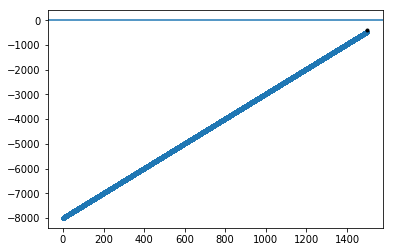

bottom


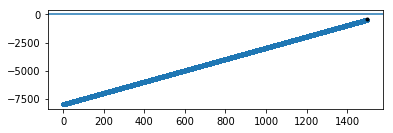

1312.0
('what it is saying is min', 60.88964154855491, 7999.88428763672)
('what it is saying is max', 60.88964154855491, 7999.88428763672)
('total Path:', 'shallow', 25219.1547714955, 'deep', 25219.1547714955)
____________________________
('min holder top', 60.88964154855491)
KANYE
4
('top', 26246.33952636719, 26246.529763183593, 26246.72)
('bottom', 26246.33952636719, 26246.529763183593, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


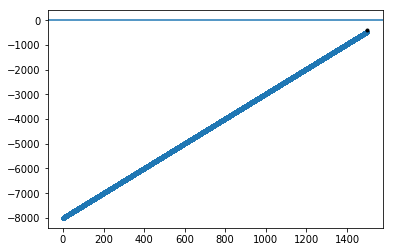

bottom


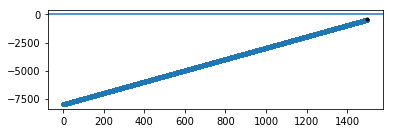

1312.0
('what it is saying is min', 60.89958780586309, 7999.94227181836)
('what it is saying is max', 60.89958780586309, 7999.94227181836)
('total Path:', 'shallow', 25219.315472148028, 'deep', 25219.315472148028)
____________________________
('min holder top', 60.89958780586309)
KANYE
4
('top', 26246.529763183593, 26246.624881591797, 26246.72)
('bottom', 26246.529763183593, 26246.624881591797, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


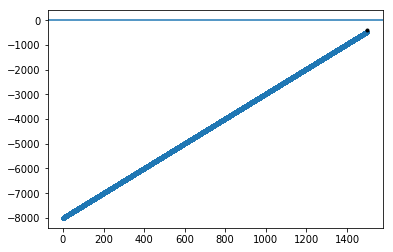

bottom


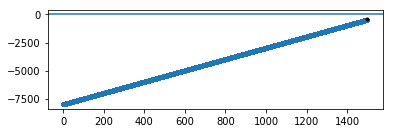

1312.0
('what it is saying is min', 60.90456148155939, 7999.97126390918)
('what it is saying is max', 60.90456148155939, 7999.97126390918)
('total Path:', 'shallow', 25219.3958224752, 'deep', 25219.3958224752)
____________________________
('min holder top', 60.90456148155939)
KANYE
4
('top', 26246.624881591797, 26246.672440795897, 26246.72)
('bottom', 26246.624881591797, 26246.672440795897, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


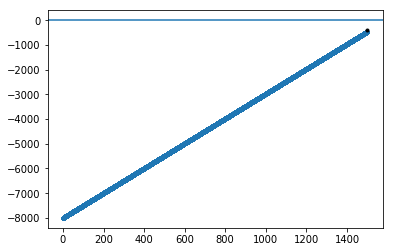

bottom


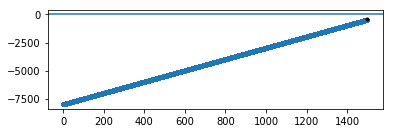

1312.0
('what it is saying is min', 60.90704847100287, 7999.98575995459)
('what it is saying is max', 60.90704847100287, 7999.98575995459)
('total Path:', 'shallow', 25219.43599761193, 'deep', 25219.43599761193)
____________________________
('min holder top', 60.90704847100287)
KANYE
4
('top', 26246.672440795897, 26246.69622039795, 26246.72)
('bottom', 26246.672440795897, 26246.69622039795, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


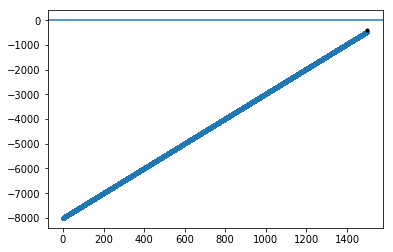

bottom


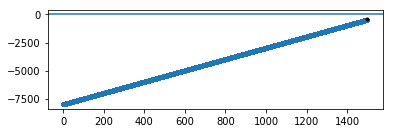

1312.0
('what it is saying is min', 60.908291999353224, 7999.993007977296)
('what it is saying is max', 60.908291999353224, 7999.993007977296)
('total Path:', 'shallow', 25219.45608519472, 'deep', 25219.45608519472)
____________________________
('min holder top', 60.908291999353224)
KANYE
4
('top', 26246.69622039795, 26246.708110198975, 26246.72)
('bottom', 26246.69622039795, 26246.708110198975, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


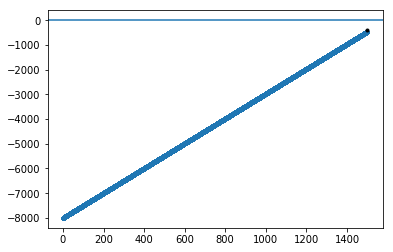

bottom


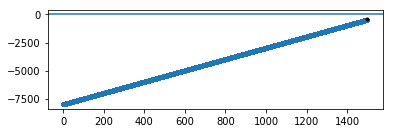

1312.0
('what it is saying is min', 60.90891376790537, 7999.996631988648)
('what it is saying is max', 60.90891376790537, 7999.996631988648)
('total Path:', 'shallow', 25219.466128995482, 'deep', 25219.466128995482)
____________________________
('min holder top', 60.90891376790537)
KANYE
4
('top', 26246.708110198975, 26246.714055099488, 26246.72)
('bottom', 26246.708110198975, 26246.714055099488, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


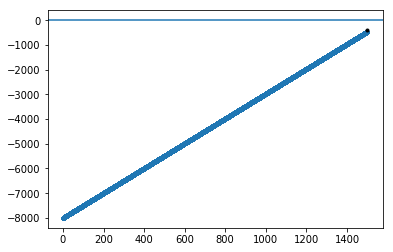

bottom


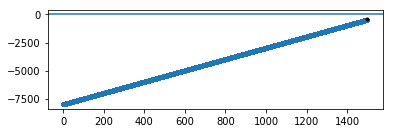

1312.0
('what it is saying is min', 60.90922466376236, 7999.998443994325)
('what it is saying is max', 60.90922466376236, 7999.998443994325)
('total Path:', 'shallow', 25219.471150925117, 'deep', 25219.471150925117)
____________________________
('min holder top', 60.90922466376236)
KANYE
4
('top', 26246.714055099488, 26246.717027549745, 26246.72)
('bottom', 26246.714055099488, 26246.717027549745, 26246.72)
****Trying Surface Ray Tracing...
****Trying Surface Ray Tracing...
___________________________
top


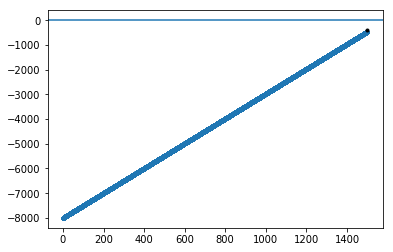

bottom


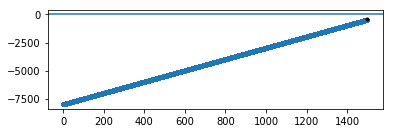

1312.0
('what it is saying is min', 60.909380097493525, 7999.999349997162)
('what it is saying is max', 60.909380097493525, 7999.999349997162)
('total Path:', 'shallow', 25219.473661875985, 'deep', 25219.473661875985)
____________________________
('min holder top', 60.909380097493525)
KANYE
4
('shallowest depth', 0.0, 'deepest depth', 3048000.0)


In [16]:
end_depthtop = 2500*3.28084
start_depthtop = depthTx[k]
end_depthbottom = 2500*3.28084
start_depthbottom = depthTx[k]
ello =0
shallowest_depth = 0
deepest_depth = 10000000
svar =1000000000000
dvar =0
u = 100000000
v = 0
top = 0
bottom = 0
top1 = 0
bottom1= 0
minRayCoordH_Stop = 0
minRayCoordV_Stop= 0
minRayCoordH_Sbottom = 0
minRayCoordV_Sbottom= 0
for k in range(0,len(depthTx)):
    
    best_HD = []
    best_VD =[]

    while (end_depthtop - start_depthtop > .005 and start_depthtop < end_depthtop and end_depthbottom - start_depthbottom > .005 and start_depthbottom < end_depthbottom):
        s = (end_depthtop + start_depthtop) / 2.0
        print("top",start_depthtop, s, end_depthtop)
        t = (end_depthbottom + start_depthbottom) / 2.0
        print("bottom", start_depthbottom, t, end_depthbottom)
        depthRxtop=[s] #depth in m of tx, negative number for above-surface pulser, positive for below surface
        depthRxbottom =[t]
        #print("top", depthRxtop[0], depthTx[k])
        #print("bottom", depthRxbottom[0], depthTx[k])
        #for k in range(0,len(depthTxm)): #swap tx and rx if needed so code doesn't break if Tx/Rx swapped
        #if (depthTxm[k]<depthRx[0] **0.3048):
         #   depthTx1=depthRx[0]
          #  depthRx[0]=depthTxm[k]
           # depthRx[0] = depthRx[0]*3.28084
            #depthTxm[k]=depthTx1**0.3048
        min_holder = 100000000000
        normalRayFlag=0 #is it a normal ray, start this flag at 0.
        end = 90.0
        start = 0.0
        numSteps = 50000 # number of rays to estimate - larger is more accurate
        stepSize = (surfaceTx[k] + abs(depthTx[k] - depthRxbottom[0])) / numSteps # triangle inequality
        print("****Trying Surface Ray Tracing...")
        county =0
        while (end - start > .005 and start < end): 
            j = (end + start) / 2.0
            #print(start,j,end)

            # code
            # ===============================================
            final_x, final_y, rayCoordH_S,rayCoordV_S, angle1, ayoo,surface_var, totalPathb,timeOfFlightb \
                = propagateRay(j, depthRxbottom[0], depthTx[k], surfaceTx[k], stepSize, numSteps, "S")
            # ========================================
            xdist = abs(final_x - surfaceTx[k])
            ydist = abs(final_y - (-1*depthTx[k]))
            #print(xdist, ydist)
            min_both = (xdist**2 + ydist**2) **(.5)
            #plt.figure(1)
            #ax= plt.subplot(111)
            
            #plt.axhline(y=0)
            #plt.plot(rayCoordH_D,rayCoordV_D, linestyle=":", marker='.')
            #plt.plot(surfaceTxm[k], -1*depthTx[k]*0.3048, marker='o', markersize=3, color="black")
            #plt.show()
            #print(depthTx[k])
            #print(min_holderD, s)
            #print("min_both", min_both)
            #if(surface_var == 1):
            if (min_both < min_holder) :
                min_holder = min_both
                minRayCoordH_Sbottom = rayCoordH_S
                minRayCoordV_Sbottom = rayCoordV_S
                totalPathSbottom = totalPathb
                timeOfFlightSbottom = timeOfFlightb
                minAngle = j
                min_holderSbottom= min_holder
            #print("min holder", min_both)
            #county +=1
            #if(surface_var == 0):
            if(final_x > surfaceTx[k]):

                end = j
                # rerun loop
            else:
                start = j
                # rerun loop
        
        min_holder = 100000000000
        normalRayFlag=0 #is it a normal ray, start this flag at 0.
        end = 90.0
        start = 0.0
        numSteps = 50000 # number of rays to estimate - larger is more accurate
        stepSize = (surfaceTx[k] + abs(depthTx[k] - depthRxtop[0])) / numSteps # triangle inequality
        print("****Trying Surface Ray Tracing...")
        county =0
        while (end - start > .005 and start < end): 
            j = (end + start) / 2.0
            #print(start,j,end)

            # code
            # ===============================================
            final_x, final_y, rayCoordH_S,rayCoordV_S, angle1, ayoo,surface_var,  totalPatht,timeOfFlightt \
                = propagateRay(j, depthRxtop[0], depthTx[k], surfaceTx[k], stepSize, numSteps, "S")
            # ========================================
            xdist = abs(final_x - surfaceTx[k])
            ydist = abs(final_y - (-1*depthTx[k]))
            #print(xdist, ydist)
            min_both = (xdist**2 + ydist**2) **(.5)
            #plt.figure(1)
            #ax= plt.subplot(111)
            
            #plt.axhline(y=0)
            #plt.plot(rayCoordH_D,rayCoordV_D, linestyle=":", marker='.')
            #plt.plot(surfaceTxm[k], -1*depthTx[k]*0.3048, marker='o', markersize=3, color="black")
            #plt.show()
            #print(depthTx[k])
            #print(min_holderD, s)
            #print("min_both", min_both)
            #if(surface_var == 1):
            if (min_both < min_holder) :
                min_holder = min_both
                minRayCoordH_Stop = rayCoordH_S
                minRayCoordV_Stop = rayCoordV_S
                totalPathStop = totalPatht
                timeOfFlightStop = timeOfFlightt
                minAngle = j
                min_holderStop = min_holder
            #print("min holder", min_both)
            #county +=1
            #if(surface_var == 0):
            if(final_x > surfaceTx[k]):

                end = j
                # rerun loop
            #elif(ayoo ==1):
            #    end = j
            else:
                start = j
        #if (final_y>=-1.*depthTx[k]-5 and final_y<-1.*depthTx[k]+5):
         #   normalRayFlag=1
            #print("Ray Tracer Converged, Normal Mode")
            #print("Initial Angle Downhole: ", j, " Final Angle in Ice: ", angle1*180/np.pi)
            #print("Horizontal Distance at End: ", locationOfRayEnd[0], " ft.")
            #print("Horizontal Distance at End: ", locationOfRayEnd[0]/3.3, " m")

            #print("Depth at End: ",locationOfRayEnd[1],"ft.")
            #print("Time Of Flight Under Ice: ", timeOfFlight, " ns")
            #print("Length of Path Under Ice: ", totalPath, " ft.")
        #else:
            #print("****Ray Tracer Did Not Converge with Normal Mode, there is no solution")

            #totalPathAll.append(totalPath)
            #timeOfFlightAll.append(timeOfFlight)
            #normalFlagAll.append(normalRayFlag)
            #initialAngleAll.append(j)
        
            #plot ray
        print("___________________________")
        plt.figure(1)
        ax= plt.subplot(111)
        print("top")
        plt.axhline(y=0)
        plt.plot(minRayCoordH_Stop,minRayCoordV_Stop, linestyle=":", marker='.')
        plt.plot(surfaceTxm[k], -1*depthTx[k]*0.3048, marker='o', markersize=3, color="black")
        plt.show()
        plt.figure(2)
        ax= plt.subplot(211)
        print("bottom")
        plt.axhline(y=0)
        plt.plot(minRayCoordH_Sbottom,minRayCoordV_Sbottom, linestyle=":", marker='.')
        plt.plot(surfaceTxm[k], -1*depthTx[k]*0.3048, marker='o', markersize=3, color="black")
        plt.show()
        print(depthTx[k])
        print("what it is saying is min", min_holderStop*0.3048, s*0.3048)
        print("what it is saying is max", min_holderSbottom*0.3048, t*0.3048)
        print("total Path:", "shallow", totalPathStop, "deep", totalPathSbottom)
        print("____________________________")
        #plt.figure(1)
        #ax= plt.subplot(111)
        print("min holder top", min_holderStop*0.3048)
        if(min_holderStop <= (3.28084)):
            print("ELLO")            
            end_depthtop = s
            hold_s = s
            if(s < svar):
                shallowest_HS = minRayCoordH_Stop 
                shallowest_VS = minRayCoordV_Stop
                shallowtotalPathSt = totalPathStop
                shallowtimeOfFlightSt= timeOfFlightStop
                shallowest_depth = s
                svar = s
            top = 1
        else:
            print("KANYE")
            #if we come out of shallowest or end up above shallowest want to move down
            #if(end_depthtop - start_depthtop > .005 and start_depthtop < end_depthtop):
            if(top == 1):
                top1 = 1
                top = 2
                print("1")

                start_depthtop = s
            elif(top1 == 1):
                start_depthtop = s
                end_depthtop = hold_s
            
            
            else:
                print("4")
                start_depthtop = s
        if(min_holderSbottom <= (3.28084)):
            print("HEY")
            
            start_depthbottom = t
            hold_t = t
            if(t > dvar):
                deepest_HS = minRayCoordH_Sbottom 
                deepest_VS = minRayCoordV_Sbottom
                deeptotalPathSb = totalPathSbottom
                deeptimeOfFlightSb= timeOfFlightSbottom
                deepest_depth = t
                dvar = t
            bottom =  1


            #end_depth = s
            #if (count == 1):
            #ello +=1
            #ax.set_ylim(ymin=-1600, ymax=0)
            #ax.set_xlim(xmin=0, xmax=5100)
            #plt.plot(minRayCoordH_D,minRayCoordV_D, linestyle=":", marker='.', color = "blue")
            #plt.plot(surfaceTxm[k], -1*depthRx[0]*0.3048, marker='o', markersize=3, color="yellow")
            #if(depthRx[0]< shallowest_depth):
            #    shallowest_depth = depthRx[0]
            #else:
             #   deepest_depth = depthRx[0]
            # rerun loop
        else:
            #if(end_depthbottom - start_depthbottom > .005 and start_depthbottom < end_depthbottom):
            if(bottom == 1):
                bottom1 = 1
                bottom = 2
                end_depthbottom= t

            elif(bottom1 == 1):
                start_depthbottom = t
                end_depthbottom = hold_t
            
            else:
                start_depthbottom = t
            #ax.set_ylim(ymin=-1600, ymax=0)
            #ax.set_xlim(xmin=0, xmax=5000)
            #plt.plot(minRayCoordH_D,minRayCoordV_D, linestyle=":", marker='.', color = "black")
            #plt.plot(surfaceTxm[k], -1*depthRx[0]*0.3048, marker='o', markersize=3, color="red")
    #plt.show()
print("shallowest depth", shallowest_depth*0.3048, "deepest depth", deepest_depth*0.3048)



In [ ]:
### plt.figure(1)
ax= plt.subplot(111)
#ax.set_ylim(ymin=-200, ymax=-50)
#ax.set_xlim(xmin=4800, xmax=5200)
plt.axhline(y=0)
plt.plot(shallowest_HS,shallowest_VS, linestyle=":", marker='.')
plt.plot(deepest_HS,deepest_VS, linestyle=":", marker='.')
plt.plot(surfaceTxm[0], -1*depthTx[0]*0.3048, marker='o', markersize=3, color="black")
plt.show()
print(shallowest_depth*.3048, deepest_depth*.3048)
print("totalPaths; shallow: deep...ft", shallowtotalPathSt, deeptotalPathSb)
print("timesOfFlights; shallow: deep...ns",  shallowtimeOfFlightSt, deeptimeOfFlightSb)

In [ ]:
H0=shallowest_HD
V0=shallowest_VD
H1=deepest_HD
V1=deepest_VD

#H2=shallowest_HR
#V2=shallowest_VR
#H3=deepest_HR
#V3=deepest_VR

H4=shallowest_HS
V4=shallowest_VS
H5=deepest_HS
V5=deepest_VS

In [ ]:
#plot ray
plt.figure(1)
ax= plt.subplot(111)
ax.set_ylim(ymin=-2500, ymax=100)
ax.set_xlim(xmin=0, xmax=5000)
plt.axhline(y=0)
plt.plot(H0,V0, linestyle=":", marker='.', color ="blue")
plt.plot(H1,V1, linestyle=":", marker='.', color = "blue")
#plt.plot(H2,V2, linestyle=":", marker='.', color = "orange")
#plt.plot(H3,V3, linestyle=":", marker='.', color = "orange")
#plt.plot(H4,V4, linestyle=":", marker='.', color = "green")
#plt.plot(H5,V5, linestyle=":", marker='.', color = "green")
plt.plot(surfaceTxm[0], -1*depthTxm[0], marker='o', markersize=3, color="black")
plt.show()
print("Direct -- totalPaths; shallow: deep...ft", shallowtotalPathDt, deeptotalPathDb)
print("Direct-- timesOfFlights; shallow: deep...ns",  shallowtimeOfFlightDt, deeptimeOfFlightDb)
print("Refracted -- totalPaths; shallow: deep...ft", shallowtotalPathRt, deeptotalPathRb)
print("Refracted -- timesOfFlights; shallow: deep...ns",  shallowtimeOfFlightRt, deeptimeOfFlightRb)
print("Surface -- totalPaths; shallow: deep...ft", shallowtotalPathSt, deeptotalPathSb)
print("Surface -- timesOfFlights; shallow: deep...ns",  shallowtimeOfFlightSt, deeptimeOfFlightSb)

In [ ]:
print time.clock() - start_time, "seconds"